Add Kaggle.json and 0002.png

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [2]:
!pip install segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 5.2 MB/s eta 0:00:00


In [3]:
!pip install git+https://github.com/qubvel/segmentation_models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-_36ehu9j
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models /tmp/pip-req-build-_36ehu9j
  Resolved https://github.com/qubvel/segmentation_models to commit e951c6747f75fa9e7240816d1c79dd2e66813123
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done


In [4]:
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

Segmentation Models: using `keras` framework.


In [5]:
import tensorflow as tf
import cv2
import glob
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

In [6]:
SIZE_X = 128 #Resize images (height  = X, width = Y)
SIZE_Y = 128

In [7]:
! pip install -q kaggle

In [8]:
 !mkdir ~/.kaggle
 !cp kaggle.json ~/.kaggle/

In [9]:
! chmod 600 ~/.kaggle/kaggle.json

In [10]:
!kaggle datasets list -s "pothole"

ref                                                         title                                            size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  ----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
atulyakumar98/pothole-detection-dataset                     Pothole Detection Dataset                       194MB  2019-12-30 14:16:08           4041        130  0.8125           
andrewmvd/pothole-detection                                 Pothole Detection                               334MB  2020-06-09 07:29:38           1100         24  0.875            
sachinpatel21/pothole-image-dataset                         Pothole Image Data-Set                          289MB  2019-08-20 09:41:08           3132         74  0.875            
chitholian/annotated-potholes-dataset                       Annotated Potholes Image Dataset        

In [11]:
!kaggle datasets download -d eyantraiit/semantic-segmentation-datasets-of-indian-roads

100% 2.67G/2.68G [00:21<00:00, 129MB/s]
100% 2.68G/2.68G [00:21<00:00, 131MB/s]


In [12]:
!unzip /content/semantic-segmentation-datasets-of-indian-roads.zip

Streaming output truncated to the last 5000 lines.
  inflating: Indian_road_data_numpy_foramt/content/images_numpy/1_018_frame119.jpg  
  inflating: Indian_road_data_numpy_foramt/content/images_numpy/1_018_frame119.npy  
  inflating: Indian_road_data_numpy_foramt/content/images_numpy/1_018_frame1190.jpg  
  inflating: Indian_road_data_numpy_foramt/content/images_numpy/1_018_frame1190.npy  
  inflating: Indian_road_data_numpy_foramt/content/images_numpy/1_018_frame1197.jpg  
  inflating: Indian_road_data_numpy_foramt/content/images_numpy/1_018_frame1197.npy  
  inflating: Indian_road_data_numpy_foramt/content/images_numpy/1_018_frame1204.jpg  
  inflating: Indian_road_data_numpy_foramt/content/images_numpy/1_018_frame1204.npy  
  inflating: Indian_road_data_numpy_foramt/content/images_numpy/1_018_frame1211.jpg  
  inflating: Indian_road_data_numpy_foramt/content/images_numpy/1_018_frame1211.npy  
  inflating: Indian_road_data_numpy_foramt/content/images_numpy/1_018_frame1218.jpg  
  inf

In [13]:
train_images = []
rootdir = "Indian_road_data/Indian_road_data/Raw_images/train"
for root, dirs, files in os.walk(rootdir):
    for name in files:
        if name.endswith((".jpg")):
            #print(img_path)
            img = cv2.imread(os.path.join(root,name), cv2.IMREAD_COLOR)       
            img = cv2.resize(img, (SIZE_Y, SIZE_X))
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            train_images.append(img)
            #train_labels.append(label)
#Convert list to array for machine learning processing        
train_images = np.array(train_images)

#Capture mask/label info as a list
train_masks = [] 
rootdir = "Indian_road_data/Indian_road_data/Masks/train"
for root, dirs, files in os.walk(rootdir):
    for name in files:
        if name.endswith((".png")):    
            mask = cv2.imread(os.path.join(root,name), 0)       
            mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
            #mask = cv2.cvtColor(mask, cv2.COLOR_RGB2BGR)
            train_masks.append(mask)
            #train_labels.append(label)
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)

In [14]:
len(train_masks)

2475

In [15]:
BACKBONE = 'resnet34'
preprocess_input = get_preprocessing(BACKBONE)

In [16]:


#Use customary x_train and y_train variables
X = train_images
Y = train_masks
#Y = np.expand_dims(Y, axis=3) #May not be necessary.. leftover from previous code 


from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# preprocess input
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)



In [17]:
import keras

In [18]:
import segmentation_models as sm

sm.set_framework('tf.keras')

sm.framework()

'tf.keras'

In [19]:
model = sm.Unet(BACKBONE, encoder_weights='imagenet')
model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score],)

print(model.summary())

85521592/85521592 [==============================] - 1s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                           

In [20]:
y_train = tf.cast(y_train, tf.float32)
y_val = tf.cast(y_val, tf.float32)
x_train = tf.cast(x_train, tf.float32)
x_val = tf.cast(x_val, tf.float32)

In [21]:
tf.config.run_functions_eagerly(True)

In [24]:
model.fit(
   x=x_train,
   y=y_train,
   batch_size=64,
   epochs=10,
   verbose=1,
   validation_data=(x_val, y_val),
)


Epoch 1/10
31/31 [==============================] - 16s 507ms/step - loss: -1334.9114 - iou_score: 89.7174 - val_loss: -1309.3551 - val_iou_score: 65.4820
Epoch 2/10
31/31 [==============================] - 14s 454ms/step - loss: -1338.3057 - iou_score: 91.1344 - val_loss: -1344.5995 - val_iou_score: 81.9738
Epoch 3/10
31/31 [==============================] - 15s 474ms/step - loss: -1340.8901 - iou_score: 92.6208 - val_loss: -1344.3666 - val_iou_score: 81.8145
Epoch 4/10
31/31 [==============================] - 12s 385ms/step - loss: -1338.7595 - iou_score: 91.4650 - val_loss: -1313.5803 - val_iou_score: 63.0177
Epoch 5/10
31/31 [==============================] - 11s 370ms/step - loss: -1340.4972 - iou_score: 92.3559 - val_loss: -1329.0040 - val_iou_score: 71.8932
Epoch 6/10
31/31 [==============================] - 12s 384ms/step - loss: -1343.9227 - iou_score: 95.1187 - val_loss: -1332.3737 - val_iou_score: 73.0054
Epoch 7/10
31/31 [==============================] - 12s 374ms/step - l

In [25]:
model.save("Unet_Resnet.hdf5")

In [26]:
from tensorflow import keras
model = keras.models.load_model('./Unet_Resnet.hdf5', compile=False)

/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 79ms/step


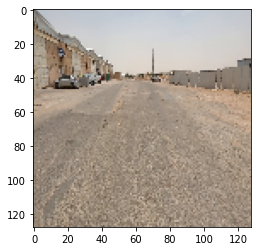

In [43]:
test_img = cv2.imread('/content/0002.png', cv2.IMREAD_COLOR)       
test_img = cv2.resize(test_img, (SIZE_Y, SIZE_X))
test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)
plt.imshow(test_img)
test_img = np.expand_dims(test_img, axis=0)

prediction = model.predict(test_img)

Size Estimation

<class 'numpy.ndarray'>


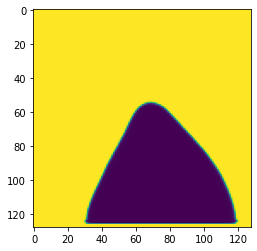

In [113]:
prediction_image = prediction.reshape(mask.shape)
plt.imshow(prediction_image)
plt.savefig('foo.png')
print(type(prediction_image)) #of float32


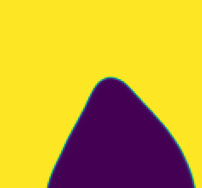

True

In [119]:
import cv2
img = cv2.imread("foo.png")
crop_img = img[50:, 50:]
crop_img = crop_img[:-50, :-50]
crop_img = crop_img[:, 70:]
crop_img = crop_img[:, :-60]
cv2_imshow(crop_img)
cv2.imwrite('boo.png', crop_img)

In [115]:
!pip install opencv-contrib-python
!pip install imutils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [116]:
# import the necessary packages
import numpy as np
import argparse
import imutils
import cv2

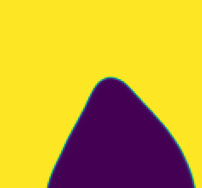

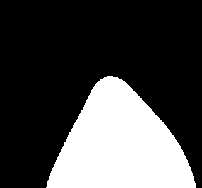

In [120]:
# load the image and display it
from google.colab.patches import cv2_imshow
import cv2

image = cv2.imread('boo.png',cv2.IMREAD_UNCHANGED)
cv2_imshow(image)
# convert the image to grayscale and threshold it
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 200, 255,cv2.THRESH_BINARY_INV)[1]
cv2_imshow(thresh)

[INFO] original, num_pts=150


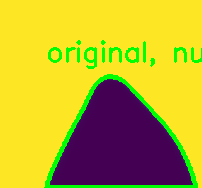

-1

In [121]:
# find the largest contour in the threshold image
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)
# draw the shape of the contour on the output image, compute the
# bounding box, and display the number of points in the contour
output = image.copy()
cv2.drawContours(output, [c], -1, (0, 255, 0), 3)
(x, y, w, h) = cv2.boundingRect(c)
text = "original, num_pts={}".format(len(c))
cv2.putText(output, text, (x, y - 15), cv2.FONT_HERSHEY_SIMPLEX,
	0.9, (0, 255, 0), 2)
# show the original contour image
print("[INFO] {}".format(text))
cv2_imshow(output)
cv2.waitKey(0)

[INFO] eps=0.0010, num_pts=98
448.53405117988586


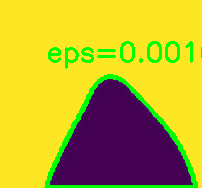

[INFO] eps=0.0064, num_pts=7
448.53405117988586


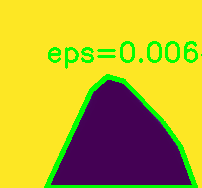

[INFO] eps=0.0119, num_pts=6
448.53405117988586


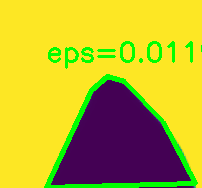

[INFO] eps=0.0173, num_pts=4
448.53405117988586


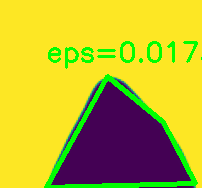

[INFO] eps=0.0228, num_pts=4
448.53405117988586


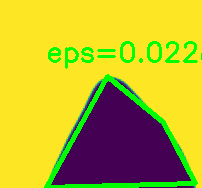

[INFO] eps=0.0282, num_pts=4
448.53405117988586


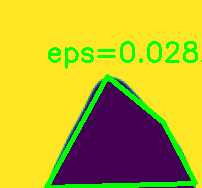

[INFO] eps=0.0337, num_pts=3
448.53405117988586


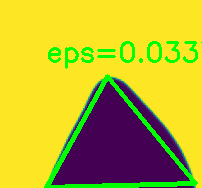

[INFO] eps=0.0391, num_pts=3
448.53405117988586


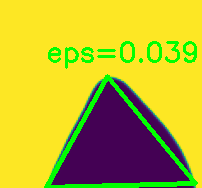

[INFO] eps=0.0446, num_pts=3
448.53405117988586


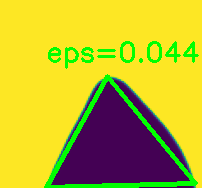

[INFO] eps=0.0500, num_pts=3
448.53405117988586


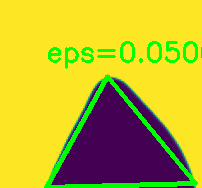

In [129]:
# to demonstrate the impact of contour approximation, let's loop
# over a number of epsilon sizes
for eps in np.linspace(0.001, 0.05, 10):
  	# approximate the contour
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, eps * peri, True)
    # draw the approximated contour on the image
    output = image.copy()
    cv2.drawContours(output, [approx], -1, (0, 255, 0), 3)
    text = "eps={:.4f}, num_pts={}".format(eps, len(approx))
    cv2.putText(output, text, (x, y - 15), cv2.FONT_HERSHEY_SIMPLEX,0.9, (0, 255, 0), 2)
    # show the approximated contour image
    print("[INFO] {}".format(text))
    print(peri)
    cv2_imshow(output)
    cv2.waitKey(0)

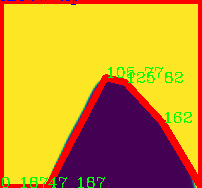

In [133]:
# Python code to find the co-ordinates of
# the contours detected in an image.
import numpy as np
import cv2

# Reading image
font = cv2.FONT_HERSHEY_COMPLEX
img2 = cv2.imread('boo.png', cv2.IMREAD_COLOR)

# Reading same image in another
# variable and converting to gray scale.
img = cv2.imread('boo.png', cv2.IMREAD_GRAYSCALE)

# Converting image to a binary image
# ( black and white only image).
_, threshold = cv2.threshold(img, 110, 255, cv2.THRESH_BINARY)

# Detecting contours in image.
contours, _= cv2.findContours(threshold, cv2.RETR_TREE,
							cv2.CHAIN_APPROX_SIMPLE)

# Going through every contours found in the image.
for cnt in contours :

	approx = cv2.approxPolyDP(cnt, 0.009 * cv2.arcLength(cnt, True), True)

	# draws boundary of contours.
	cv2.drawContours(img2, [approx], 0, (0, 0, 255), 5)

	# Used to flatted the array containing
	# the co-ordinates of the vertices.
	n = approx.ravel()
	i = 0

	for j in n :
		if(i % 2 == 0):
			x = n[i]
			y = n[i + 1]

			# String containing the co-ordinates.
			string = str(x) + " " + str(y)

			if(i == 0):
				# text on topmost co-ordinate.
				cv2.putText(img2, "Arrow tip", (x, y),
								font, 0.5, (255, 0, 0))
			else:
				# text on remaining co-ordinates.
				cv2.putText(img2, string, (x, y),
						font, 0.5, (0, 255, 0))
		i = i + 1

# Showing the final image.
cv2_imshow(img2)

# Exiting the window if 'q' is pressed on the keyboard.
if cv2.waitKey(0) & 0xFF == ord('q'):
	cv2.destroyAllWindows()


In [137]:
(w, h)

(150, 112)